# Neuro-Genomics Course - Home Exercise 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.stats import pearsonr

## **Part 1** - Normalization of sequencing data


In [2]:
# plot the algorithms results
def plot_normalization_result(X, Y, corrected_X, corrected_Y, title):
    # Plotting
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"{title}", fontsize=16)
    plt.subplot(2, 2, 1)
    plt.hist(X, bins=20, alpha=0.5, label='X - before', color='blue')
    plt.hist(Y, bins=20, alpha=0.5, label='Y - Before', color='red')
    plt.title('Vectors Histogram Before Normalization')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.hist(corrected_X, bins=20, alpha=0.5, label='X - After', color='blue')
    plt.hist(corrected_Y, bins=20, alpha=0.5, label='Y - After', color='green')
    plt.title('Vectors Histogram After Normalization')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


#### a) Implement TMM normalization

In [3]:
def tmm_normalization(X, Y, D):
    """TMM normalization method.

    Args:
        X (list or numpy array): Reference vector with values Xi.
        Y (list or numpy array): Normalized vector with values Yi.
        D (float): A constant between 0 and 1.

    Returns:
        X (list or numpy array): The reference vector.
        corrected_Y (list or numpy array):vector Y scaled by the normalization factor.
        factor (float): the normalization factor.

    """
    #Check that X and Y have the same length
    if len(X) != len(Y):
        raise ValueError("X and Y must have the same length")
    if not (0 < D < 1):
        raise ValueError("D must be between 0 and 1")
    

    # Step 1: Compute the M folds and weights
    M_folds = []
    weights = []
    for Xi, Yi in zip(X, Y):
        if Xi != 0 and Yi != 0:
            Mi = np.log(Yi / Xi)
            Wi = np.sqrt((Xi + Yi) / 2) # Compute the weight
            M_folds.append(Mi)
            weights.append(Wi)
    M_folds = np.array(M_folds)
    weights = np.array(weights)

    # Step 2: Sort and trim M folds and compute TMM
    sorted_indices = np.argsort(M_folds)
    sorted_M_folds = M_folds[sorted_indices]
    sorted_weights = weights[sorted_indices]
    # Step 3: Trim the upper and lower percentages of the data
    n = len(M_folds)
    lower_idx = int(np.floor((D / 2) * n)); higher_idx = int(np.ceil((1 - D / 2) * n))
    trimmed_M_folds = sorted_M_folds[lower_idx:higher_idx]; trimmed_weights = sorted_weights[lower_idx:higher_idx]
    # Step 4: Get the TMM
    TMM = np.sum(trimmed_weights * trimmed_M_folds) / np.sum(trimmed_weights)
    # Step 5: Compute the normalization factor
    factor = np.exp(TMM)
    # Step 6: Correct vector Y
    corrected_Y = Y / factor
    X = np.log(X + 1); Y = np.log(Y + 1); corrected_Y = np.log(corrected_Y + 1)
    plot_normalization_result(X, Y, X, corrected_Y, title="TMM normalization algorithm")

    return X, corrected_Y, factor

#### b) Implement quantile normalization

In [4]:
def quantile_normalization(X, Y):
    """quantile normalization method.

    Args:
        X (list or numpy array): Reference vector with values Xi.
        Y (list or numpy array): Normalized vector with values Yi.

    Returns:
        corrected_X (list or numpy array): vector X normalized.
        corrected_Y (list or numpy array): vector Y normalized.
    """
    # Step 1: Stack the vectors into a matrix
    matrix = np.vstack([X, Y])
    
    # Step 2: Sort each vector (row-wise)
    sorted_matrix = np.sort(matrix, axis=1)
    
    # Step 3: Compute the mean of each column across the vectors
    mean_sorted = np.mean(sorted_matrix, axis=0)

    # Step 4: Replace the values with the corresponding column mean (based on ranks)
    normalized_matrix = np.zeros_like(matrix)
    for idx, vector in enumerate(matrix):
        # Get the ranks of the original values
        ranks = np.argsort(np.argsort(vector))
        # Assign the mean values based on the ranks
        normalized_matrix[idx] = mean_sorted[ranks]
    
    # Return the normalized vectors
    corrected_X, corrected_Y = normalized_matrix[0], normalized_matrix[1]
    X = np.log(X + 1); Y = np.log(Y + 1); corrected_X = np.log(corrected_X + 1); corrected_Y = np.log(corrected_Y + 1)
    plot_normalization_result(X, Y, corrected_X, corrected_Y, title="quantile normalization algorithm")
    return corrected_X, corrected_Y
    

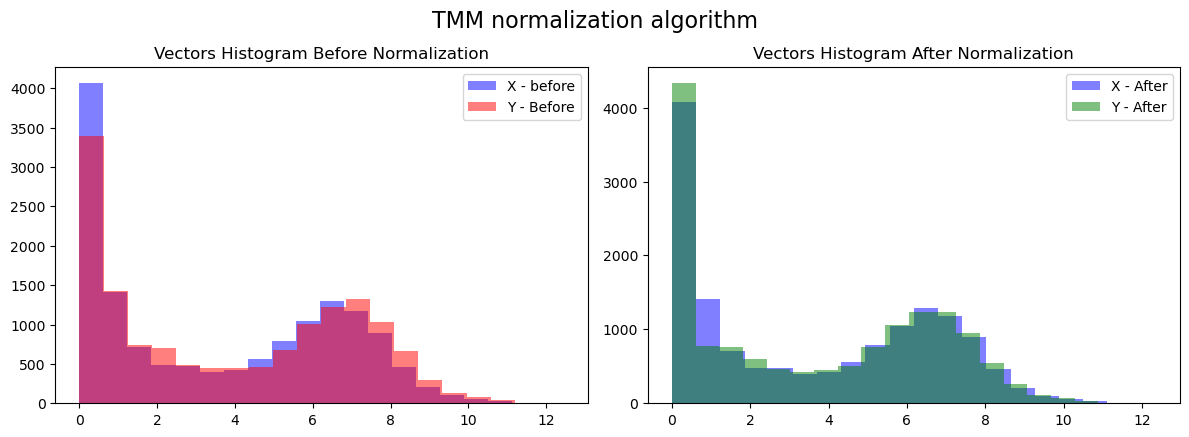

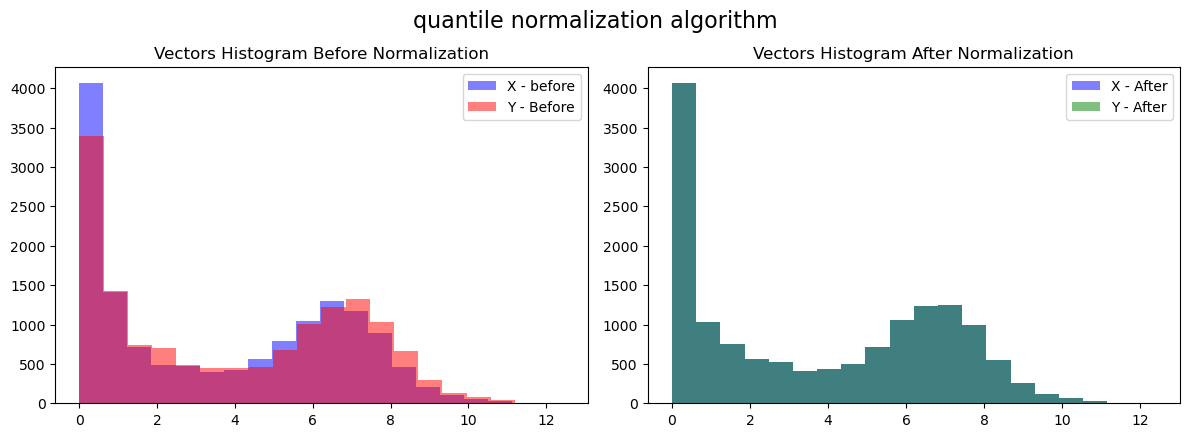

In [5]:

# Run the function on two vectors from the ‘pasilla’ data
file="/Users/adioiz/Documents/Learnings/Neuro-Genomics Course/Home Exc 2/pasilla_gene_counts.tsv"
pasilla_data = pd.read_csv(file, sep='\t', index_col=0)
X = pasilla_data['untreated1'].values
Y = pasilla_data['treated1'].values
D = 0.1

_, Y_normalaized_tmm, normalization_factor = tmm_normalization(X, Y, D)
X_normalaized_quantile, Y_normalaized_quantile = quantile_normalization(X, Y)


## Part 2 - Detect rhythmical patterns using Fourier transform
## IN R SCRIPT

#### The permutation will shuffle the data in a way that preserves statistical properties while removing any potential biological signals. We can achieve this by shuffling the expression levels within each column (time point), which ensures no circadian rhythm is preserved.

## Part 3 - Hierarchical clustering

In [4]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import pearsonr

def hierarchical_clustering(data, gene_names, K):
    """
    Perform hierarchical clustering on gene expression levels data.

    Parameters:
        data (numpy array): Matrix where each row is a gene and each column is an experimental condition.
        gene_names (list): List of names of genes corresponding to rows of the matrix.
        K (int): Number of clusters.

    Returns:
        clusters (list): A list of K clusters, where each cluster is a list of gene names.
    """
    N = data.shape[0]
    if K > N:
        raise ValueError("K cannot be greater than the number of genes.")

    # Step 1: Initialize clusters and Compute the initial distance matrix using Pearson

    clusters = [[i] for i in range(N)]
    cluster_sizes = {i: 1 for i in range(N)}

    D = np.full((N, N), np.inf)  # distance matrix
    for i in range(N):
        for j in range(i + 1, N):  # Only compute upper triangular part
            r, _ = pearsonr(data[i, :], data[j, :])  # Pearson correlation
            D[i, j] = D[j, i] = 1 - r # Convert correlation to distance


    # Step 2: Perform clustering
    while len(clusters) > K:
        # Find the closest pair of clusters
        min_dist = np.inf
        closest_pair = (0, 0)
        for i in range(len(D)):
            for j in range(i + 1, len(D)):
                if D[i, j] < min_dist:
                    min_dist = D[i, j]
                    closest_pair = (i, j)
        i, j = closest_pair

        # Merge clusters i and j
        clusters[i].extend(clusters[j])  # Merge gene indices
        cluster_sizes[i] += cluster_sizes[j]
        clusters.pop(j)  # Remove cluster j

        # Update the distance matrix
        for k in range(len(D)):
            if k != i and k != j:
                D[i, k] = D[k, i] = (cluster_sizes[i] / (cluster_sizes[i] + cluster_sizes[j])) * D[i, k] + \
                                    (cluster_sizes[j] / (cluster_sizes[i] + cluster_sizes[j])) * D[j, k]
        
        # Delete row/column j
        D = np.delete(D, j, axis=0)
        D = np.delete(D, j, axis=1)

    # Map cluster indices to gene names
    final_clusters = [[gene_names[idx] for idx in cluster] for cluster in clusters]
    return final_clusters


file_path = "/Users/adioiz/Documents/Learnings/Neuro-Genomics Course/Home Exc 2/genes_above_threshold.csv"
genes_clustering = pd.read_csv(file_path)
genes_clustering = np.array(genes_clustering)
numeric_data = genes_clustering[:, 1:-1].astype(float)

# Organize the data to perform clustering
numeric_data[np.isnan(numeric_data)] = 0
non_zero_rows = ~np.all(numeric_data == 0, axis=1)
non_nan_rows = [not (isinstance(v, float) and math.isnan(v)) for v in genes_clustering[:, -1]]

non_zero_or_nan_rows = non_zero_rows & non_nan_rows
genes_clustering = genes_clustering[non_zero_or_nan_rows, :]
numeric_data = numeric_data[non_zero_or_nan_rows, :]
gene_names = genes_clustering[:, -1]


clusters = hierarchical_clustering(numeric_data, gene_names, K = 6)

# Print final clusters
for idx, cluster in enumerate(clusters):
    print(f"Cluster {idx+1}: {cluster}")

KeyboardInterrupt: 